In [1]:
import arviz as az
import matplotlib.pylab as plt
import matplotlib as mpl
mpl.style.use('plotting.mplstyle')
import numpy as np
np.random.seed(15)
import h5py
from read_O3_LVK_results import *
from scipy.special import erf
from scipy.optimize import minimize

In [2]:
# Load AR results
precomputed_data = h5py.File("./../data/ar_Xeff_Xp_summary.hdf","r")
Xeffs = precomputed_data['posterior/Xeffs'][()]
Xps = precomputed_data['posterior/Xps'][()]
dR_dXeffs = precomputed_data['posterior/dR_dXeffs'][()]
dR_dXps = precomputed_data['posterior/dR_dXps'][()]
f_Xeffs = precomputed_data['posterior/f_Xeffs'][()]
f_Xps = precomputed_data['posterior/f_Xps'][()]

# Construct normalized probability distributions
p_Xeff = f_Xeffs/np.trapz(f_Xeffs,Xeffs,axis=0)
p_Xp = f_Xps/np.trapz(f_Xps,Xps,axis=0)

## 1. Get fit to AR results with example parametric models

In [3]:
# Define a few possible parametric models to fit

def truncatedNormal(x,mu,sig,xmin):
    
    """
    Truncated Gaussian probability distribution, normalized on (xmin,1)
    
    Parameters
    ----------
    x : Location at which to evaluate distribution
    mu : Mean parameter
    sig : Standard deviation parameter
    xmin : Lower bound
    """
    
    norm = 0.5*(erf((1.-mu)/np.sqrt(2.*sig**2)) - erf((xmin-mu)/np.sqrt(2.*sig**2)))
    px = np.exp(-(x-mu)**2/(2.*sig**2))/np.sqrt(2.*np.pi*sig**2)/norm
    px[x<xmin]=0
    return px

def lorentzian(x,mu,gamma,xmin):
    
    """
    Truncated Lorentzian probability distribution, normalized on (xmin,1)
    
    Parameters
    ----------
    x : Location at which to evaluate distribution
    mu : Mean parameter
    gamma : width parameter
    xmin : Lower bound
    """    
    
    norm = (np.arctan((1.-mu)/gamma) - np.arctan((xmin-mu)/gamma))/np.pi
    px = (1./(np.pi*gamma))*1./(1.+((x-mu)/gamma)**2)/norm
    px[x<xmin]=0
    return px

True [0.05789102 0.1111059 ]
True [0.06111891 0.086907  ]


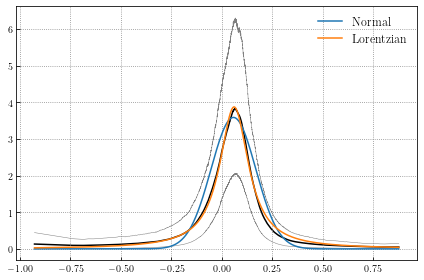

In [4]:
# Initial guesses for parameters matching AR Xeff results
xeff_gaussian_mu = 0.06
xeff_gaussian_sigma = 0.12
xeff_lorentzian_mu = 0.06
xeff_lorentzian_gamma = 0.1

# Fit to our PPD on Xeff
p_Xeff_target = np.mean(p_Xeff,axis=1)

# Define sum-of-squares loss functions for both models
def ls_xeff_gaussian(params):
    mu,sig = params
    p_Xeff_model = truncatedNormal(Xeffs,mu,sig,-1)
    return np.trapz((p_Xeff_model-p_Xeff_target)**2,Xeffs)

def ls_xeff_lorentzian(params):
    mu,gamma = params
    p_Xeff_model = lorentzian(Xeffs,mu,gamma,-1)
    return np.trapz((p_Xeff_model-p_Xeff_target)**2,Xeffs)

# Fit each model!
initial_params_xeff_gaussian = (xeff_gaussian_mu,xeff_gaussian_sigma)
xeff_gaussian_soln = minimize(ls_xeff_gaussian,
                         initial_params_xeff_gaussian,
                         method='Nelder-Mead',
                         bounds=[(0,1),(None,None)],
                         options={'maxiter':1e5})

initial_params_xeff_lorentzian = (xeff_lorentzian_mu,xeff_lorentzian_gamma)
xeff_lorentzian_soln = minimize(ls_xeff_lorentzian,
                         initial_params_xeff_lorentzian,
                         method='Nelder-Mead',
                         bounds=[(0,1),(None,None)],
                         options={'maxiter':1e5})

print(xeff_gaussian_soln.success,xeff_gaussian_soln.x)
print(xeff_lorentzian_soln.success,xeff_lorentzian_soln.x)

# Plot to check consistency with our data
fig,ax = plt.subplots(figsize=(6,4))

# AR result
ax.plot(Xeffs,np.mean(p_Xeff,axis=1),color='black',zorder=1)
ax.plot(Xeffs,np.quantile(p_Xeff,0.05,axis=1),color='grey',lw=0.5,zorder=1)
ax.plot(Xeffs,np.quantile(p_Xeff,0.95,axis=1),color='grey',lw=0.5,zorder=1)

ax.plot(Xeffs,truncatedNormal(Xeffs,*xeff_gaussian_soln.x,-1),label='Normal')
ax.plot(Xeffs,lorentzian(Xeffs,*xeff_lorentzian_soln.x,-1),label='Lorentzian')

plt.legend()
plt.tight_layout()
plt.show()

True [5.60374931e-06 3.66484240e-01]
True [0.         0.29995673]


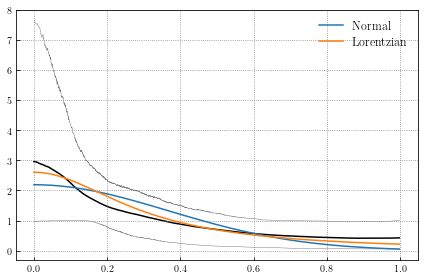

In [5]:
# Similarly, initial guesses for chi_p
xp_gaussian_mu = 0.0
xp_gaussian_sigma = 0.5
xp_lorentzian_mu = 0.0
xp_lorentzian_gamma = 0.35

# Fit to our PPD
p_Xp_target = np.mean(p_Xp,axis=1)

# Sum-of-squares loss functions
def ls_xp_gaussian(params):
    mu,sig = params
    p_Xp_model = truncatedNormal(Xps,mu,sig,0) 
    return np.trapz((p_Xp_model-p_Xp_target)**2,Xps)

def ls_xp_lorentzian(params):
    mu,gamma = params
    p_Xp_model = lorentzian(Xps,mu,gamma,0)
    return np.trapz((p_Xp_model-p_Xp_target)**2,Xps)

# Fit!
initial_params_xp_gaussian = (xp_gaussian_mu,xp_gaussian_sigma)
xp_gaussian_soln = minimize(ls_xp_gaussian,
                         initial_params_xp_gaussian,
                         method='Nelder-Mead',
                         bounds=[(0,1),(None,None)],
                         options={'maxiter':1e5})

initial_params_xp_lorentzian = (xp_lorentzian_mu,xp_lorentzian_gamma)
xp_lorentzian_soln = minimize(ls_xp_lorentzian,
                         initial_params_xp_lorentzian,
                         method='Nelder-Mead',
                         bounds=[(0,1),(None,None)],
                         options={'maxiter':1e5})

print(xp_gaussian_soln.success,xp_gaussian_soln.x)
print(xp_lorentzian_soln.success,xp_lorentzian_soln.x)

# Plot result
fig,ax = plt.subplots(figsize=(6,4))

# AR result
ax.plot(Xps,np.mean(p_Xp,axis=1),color='black',zorder=1)
ax.plot(Xps,np.quantile(p_Xp,0.05,axis=1),color='grey',lw=0.5,zorder=1)
ax.plot(Xps,np.quantile(p_Xp,0.95,axis=1),color='grey',lw=0.5,zorder=1)

ax.plot(Xps,truncatedNormal(Xps,*xp_gaussian_soln.x,0),label='Normal')
ax.plot(Xps,lorentzian(Xps,*xp_lorentzian_soln.x,0),label='Lorentzian')

plt.legend()
plt.tight_layout()
plt.show()

In [6]:
# Save our fitting results

xeff_gaussian_mean,xeff_gaussian_std = xeff_gaussian_soln.x
xeff_lorentzian_mean,xeff_lorentzian_gamma = xeff_lorentzian_soln.x
xp_gaussian_mean,xp_gaussian_std = xp_gaussian_soln.x
xp_lorentzian_mean,xp_lorentzian_gamma = xp_lorentzian_soln.x

with open('./../macros/fitting_results_effective_spins.txt','w') as macrofile:
    
    macrofile.write("\\newcommand{{\\ChiEffFitGaussianMean}}{{{0:.2f}}}".format(xeff_gaussian_mean))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\ChiEffFitGaussianStd}}{{{0:.2f}}}".format(xeff_gaussian_std))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\ChiEffFitLorentzianMean}}{{{0:.2f}}}".format(xeff_lorentzian_mean))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\ChiEffFitLorentzianGamma}}{{{0:.2f}}}".format(xeff_lorentzian_gamma))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\ChiPFitGaussianMean}}{{{0:.1f}}}".format(xp_gaussian_mean))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\ChiPFitGaussianStd}}{{{0:.2f}}}".format(xp_gaussian_std))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\ChiPFitLorentzianMean}}{{{0:.1f}}}".format(xp_lorentzian_mean))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\ChiPFitLorentzianGamma}}{{{0:.2f}}}".format(xp_lorentzian_gamma))
    macrofile.write("\n")

## 2. Compare AR results, LVK results, and parametric fits

In [7]:
# Load joint probability distribution on Xeff and Xp from LVK fits
lvk_Xeff_grid,lvk_Xp_grid,lvk_R_ref,lvk_p_Xeff_Xp = get_lvk_gaussian_spin()

# Convert from a probability distribution p(Xeff,Xp) to a differential rate over effective spin parameters
lvk_R_Xeff_Xp = lvk_R_ref[:,np.newaxis,np.newaxis]*lvk_p_Xeff_Xp

# Get grid locations corresponding to our reference Xeff and Xp values
# and get 1D probability distributions at fixed to each of these reference values
ind_Xeff_ref = np.argmin(np.abs(lvk_Xeff_grid-0.05))
ind_Xp_ref = np.argmin(np.abs(lvk_Xp_grid-0.1))
lvk_R_Xeff = lvk_R_Xeff_Xp[:,:,ind_Xp_ref]
lvk_R_Xp = lvk_R_Xeff_Xp[:,ind_Xeff_ref,:]

# Normalize to a 1D probability distribution
lvk_p_Xeff = lvk_R_Xeff/np.trapz(lvk_R_Xeff,lvk_Xeff_grid,axis=1)[:,np.newaxis]
lvk_p_Xp = lvk_R_Xp/np.trapz(lvk_R_Xp,lvk_Xp_grid,axis=1)[:,np.newaxis]

Removing  GW170817
Removing  S190425z
Removing  S190426c
Removing  S190814bv
Removing  S190917u
Removing  S200105ae
Removing  S200115j
39760 !!!


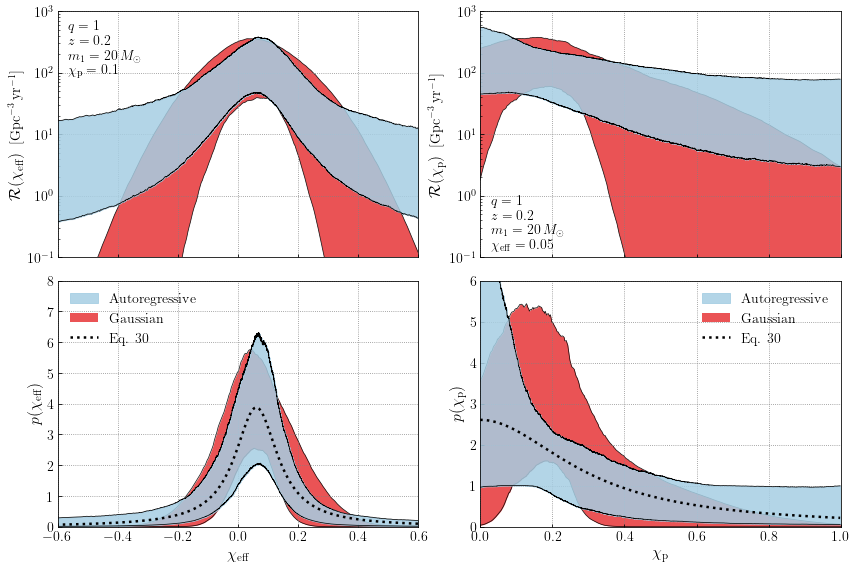

In [8]:
#########################
# Merger rate vs. Xeff
#########################

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(221)
ax.set_rasterization_zorder(4)
    
# AR result
ax.plot(Xeffs,np.quantile(dR_dXeffs,0.05,axis=1),color='black',lw=0.775,zorder=3)
ax.plot(Xeffs,np.quantile(dR_dXeffs,0.95,axis=1),color='black',lw=0.775,zorder=3)
ax.fill_between(Xeffs,
                np.quantile(dR_dXeffs,0.05,axis=1),
                np.quantile(dR_dXeffs,0.95,axis=1),
                color='#a6cee3',alpha=0.85,zorder=2)

# LVK result
ax.plot(lvk_Xeff_grid,np.quantile(lvk_R_Xeff,0.05,axis=0),color='black',lw=0.75,alpha=0.9,zorder=1)
ax.plot(lvk_Xeff_grid,np.quantile(lvk_R_Xeff,0.95,axis=0),color='black',lw=0.75,alpha=0.9,zorder=1)
ax.fill_between(lvk_Xeff_grid,
                np.quantile(lvk_R_Xeff,0.05,axis=0),
                np.quantile(lvk_R_Xeff,0.95,axis=0),
                color='#e31a1c',alpha=0.75,zorder=0,lw=0)

# Misc formatting
ax.tick_params(labelsize=14)
ax.set_xlim(-0.6,0.6)
ax.set_ylim(1e-1,1e3)
ax.set_yscale('log')
ax.set_xticklabels([])
ax.set_ylabel(r'$\mathcal{R}(\chi_\mathrm{eff})$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}$]}',fontsize=16)

# Annotate with reference values
ax.text(0.03,0.94,r'$q=1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.text(0.03,0.88,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.text(0.03,0.82,r'$m_1=20\,M_\odot$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.text(0.03,0.76,r'$\chi_\mathrm{p}=0.1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)

#########################
# Merger rate vs. Xp
#########################

ax = fig.add_subplot(222)
ax.set_rasterization_zorder(4)

# AR results
ax.plot(Xps,np.quantile(dR_dXps,0.05,axis=1),color='black',lw=0.75,zorder=3)
ax.plot(Xps,np.quantile(dR_dXps,0.95,axis=1),color='black',lw=0.75,zorder=3)
ax.fill_between(Xps,
                np.quantile(dR_dXps,0.05,axis=1),
                np.quantile(dR_dXps,0.95,axis=1),
                color='#a6cee3',alpha=0.85,zorder=2)

# LVK
ax.plot(lvk_Xp_grid,np.quantile(lvk_R_Xp,0.05,axis=0),color='black',lw=0.75,alpha=0.9,zorder=1)
ax.plot(lvk_Xp_grid,np.quantile(lvk_R_Xp,0.95,axis=0),color='black',lw=0.75,alpha=0.9,zorder=1)
ax.fill_between(lvk_Xp_grid,
                np.quantile(lvk_R_Xp,0.05,axis=0),
                np.quantile(lvk_R_Xp,0.95,axis=0),
                color='#e31a1c',alpha=0.75,zorder=0,lw=0)

# Misc formatting
ax.tick_params(labelsize=14)
ax.set_xlim(0,1)
ax.set_ylim(1e-1,1e3)
ax.set_yscale('log')
ax.set_xticklabels([])
ax.set_ylabel(r'$\mathcal{R}(\chi_\mathrm{p})$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}$]}',fontsize=16)

# Reference values
ax.text(0.03,0.23,r'$q=1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.text(0.03,0.17,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.text(0.03,0.11,r'$m_1=20\,M_\odot$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.text(0.03,0.05,r'$\chi_\mathrm{eff} = 0.05$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)

####################################
# Probability distribution of Xeffs
####################################

ax = fig.add_subplot(223)
ax.set_rasterization_zorder(4)

# AR
ax.plot(Xeffs,np.quantile(p_Xeff,0.05,axis=1),color='black',lw=0.75,zorder=3)
ax.plot(Xeffs,np.quantile(p_Xeff,0.95,axis=1),color='black',lw=0.75,zorder=3)
ax.fill_between(Xeffs,
                np.quantile(p_Xeff,0.05,axis=1),
                np.quantile(p_Xeff,0.95,axis=1),
                label='Autoregressive',
                color='#a6cee3',alpha=0.85,zorder=2)

# LVK
ax.plot(lvk_Xeff_grid,np.quantile(lvk_p_Xeff,0.05,axis=0),color='black',lw=0.75,alpha=0.9,zorder=1)
ax.plot(lvk_Xeff_grid,np.quantile(lvk_p_Xeff,0.95,axis=0),color='black',lw=0.75,alpha=0.9,zorder=1)
ax.fill_between(lvk_Xeff_grid,
                np.quantile(lvk_p_Xeff,0.05,axis=0),
                np.quantile(lvk_p_Xeff,0.95,axis=0),
                label='Gaussian',
                color='#e31a1c',alpha=0.75,zorder=0,lw=0)

# Plot parameteric fit
ax.plot(Xeffs,lorentzian(Xeffs,*xeff_lorentzian_soln.x,-1),color='black',ls=':',lw=2.5,label='Eq. 30')

# Misc formatting
ax.legend(loc='upper left',frameon=False,fontsize=14)
ax.tick_params(labelsize=14)
ax.set_xlim(-0.6,0.6)
ax.set_ylim(0,8)
ax.set_xlabel('$\chi_\mathrm{eff}$',fontsize=16)
ax.set_ylabel(r'$p(\chi_\mathrm{eff})$',fontsize=16)

####################################
# Probability distribution of Xps
####################################

ax = fig.add_subplot(224)
ax.set_rasterization_zorder(4)

# AR
ax.plot(Xps,np.quantile(p_Xp,0.05,axis=1),color='black',lw=0.75,zorder=3)
ax.plot(Xps,np.quantile(p_Xp,0.95,axis=1),color='black',lw=0.75,zorder=3)
ax.fill_between(Xps,
                np.quantile(p_Xp,0.05,axis=1),
                np.quantile(p_Xp,0.95,axis=1),
                label='Autoregressive',
                color='#a6cee3',alpha=0.85,zorder=2)

# LVK
ax.plot(lvk_Xp_grid,np.quantile(lvk_p_Xp,0.05,axis=0),color='black',lw=0.75,alpha=0.9,zorder=1)
ax.plot(lvk_Xp_grid,np.quantile(lvk_p_Xp,0.95,axis=0),color='black',lw=0.75,alpha=0.9,zorder=1)
ax.fill_between(lvk_Xp_grid,
                np.quantile(lvk_p_Xp,0.05,axis=0),
                np.quantile(lvk_p_Xp,0.95,axis=0),
                label='Gaussian',
                color='#e31a1c',alpha=0.75,zorder=0,lw=0)

# Parametric fit
ax.plot(Xps,lorentzian(Xps,*xp_lorentzian_soln.x,0),color='black',ls=':',lw=2.5,label='Eq. 30')

# Misc formatting
ax.legend(loc='upper right',frameon=False,fontsize=14)
ax.tick_params(labelsize=14)
ax.set_xlim(0,1)
ax.set_ylim(0,6)
ax.set_xlabel('$\chi_\mathrm{p}$',fontsize=16)
ax.set_ylabel(r'$p(\chi_\mathrm{p})$',fontsize=16)

plt.tight_layout()
plt.savefig('figure_13.pdf',bbox_inches='tight',dpi=200)
plt.show()